# Chapter 9: GANs and Adversarial Examples
A GAN is a framework that's used to generate new data by learning the distribution of data.

# Creating the dataset

### 1. Import the essential packages:

In [1]:
from torchvision import datasets
import torchvision.transforms as transforms
import os

path2data = "./data/chapter_9"
os.makedirs(path2data, exist_ok=True)

### 2. Define the data transformations:

In [2]:
h, w = 64, 64
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
transform = transforms.Compose([
    transforms.Resize((h, w)),
    transforms.CenterCrop((h, w)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

### 3. Instantiate an object of the STL-10 class:

In [3]:
train_ds = datasets.STL10(path2data, split='train',
                          download=True,
                          transform=transform)
print(len(train_ds))

Extracting ./data/chapter_9/stl10_binary.tar.gz to ./data/chapter_9
5000


### 4. Get a sample tensor from the dataset:

In [4]:
import torch
for x, _ in train_ds:
    print(x.shape, torch.min(x), torch.max(x))
    break

torch.Size([3, 64, 64]) tensor(-0.8980) tensor(0.9529)


### 5. Let's display the sample tensor:

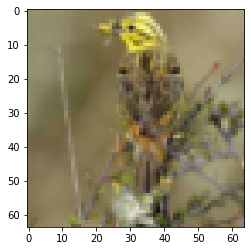

In [6]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

plt.imshow(to_pil_image(0.5*x + 0.5))

### 6. Create the dataloader:

In [8]:
import torch

batch_size = 32
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=batch_size,
                                       shuffle=True)

###  7. Get a data batch from the dataloader

In [9]:
for x, y in train_dl:
    print(x.shape, y.shape)
    break

torch.Size([32, 3, 64, 64]) torch.Size([32])


## Defining the generator and discriminator

### 1. Define the Generator class:

In [13]:
from torch import nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, params):
        super(Generator, self).__init__()
        nz = params["nz"]
        ngf = params["ngf"]
        noc = params["noc"]
        self.dconv1 = nn.ConvTranspose2d(nz, ngf * 8,
                                         kernel_size=4, stride=1,
                                         padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 8)
        self.dconv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4,
                                         kernel_size=4, stride=2,
                                         padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 4)
        self.dconv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2,
                                         kernel_size=4, stride=2,
                                         padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 2)
        self.dconv4 = nn.ConvTranspose2d(ngf * 2, ngf,
                                         kernel_size=4, stride=2,
                                         padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)
        self.dconv5 = nn.ConvTranspose2d(ngf, noc, kernel_size=4,
                                         stride=2, padding=1,
                                         bias=False)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.dconv1(x)))
        x = F.relu(self.bn2(self.dconv2(x)))
        x = F.relu(self.bn3(self.dconv3(x)))
        x = F.relu(self.bn4(self.dconv4(x)))
        out = torch.tanh(self.dconv5(x))
        return out

### 2. Define an object of the Generator class:

In [14]:
params_gen = {
    "nz": 100,
    "ngf": 64,
    "noc": 3,
}
model_gen = Generator(params_gen)
device = torch.device("cuda")
model_gen.to(device)
print(model_gen)

Generator(
  (dconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


### 3. Define the Discrinator class:

In [15]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super(Discriminator, self).__init__()
        nic = params["nic"]
        ndf = params["ndf"]
        self.conv1 = nn.Conv2d(nic, ndf, kernel_size=4, stride=2,
                               padding=1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, kernel_size=4,
                               stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4,
                               stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4,
                               stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, 1, kernel_size=4,
                               stride=1, padding=0, bias=False)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, inplace=True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, inplace=True)
        out = torch.sigmoid(self.conv5(x))
        return out.view(-1)

### 4. Define an object of the Discriminator class:

In [16]:
params_dis = {
    "nic": 3,
    "ndf": 64
}
model_dis = Discriminator(params_dis)
model_dis.to(device)
print(model_dis)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


Let's pass some dummy input to the model:

In [17]:
with torch.no_grad():
    y = model_dis(torch.zeros(1, 3, h, w, device=device))

print(y.shape)

torch.Size([1])


### 5. Define a helper function to initialize the model weights:

In [18]:
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:

SyntaxError: unexpected EOF while parsing (<ipython-input-18-44677b276d7a>, line 3)